In [ ]:
!pip install tensorflow opencv-python matplotlib
!pip list

In [39]:
import tensorflow as tf
import os
import cv2
import stat
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# if using gpus to run ANN, allocates only certain amount of GPU memory towards ANN
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
    tf.config.experimental.set_memory_growth(gpu, True)

Found 697 images belonging to 3 classes.


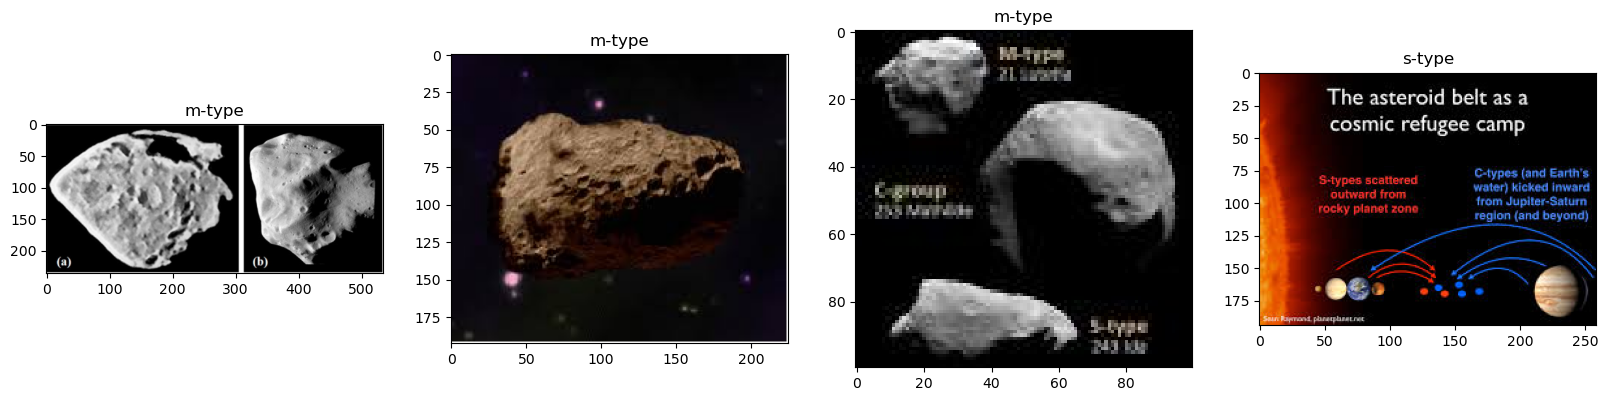

In [40]:
# remove unsupported image files from the directory
img_directory = 'images_asteroids'
for img_class in os.listdir(img_directory):
    for img in os.listdir(os.path.join(img_directory, img_class)):
        img_path = os.path.join(img_directory, img_class, img)
        img_type = imghdr.what(img_path)
        if img_type not in ['jpeg', 'jpg', 'png']:
            print('Removing image {}'.format(img_path))
            os.chmod(img_path, stat.S_IWRITE)
            os.remove(img_path)

# creating a dataset to print 4 random images
image_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
data_generator = image_datagen.flow_from_directory(
    img_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True)

# plots the 4 images
class_labels = list(data_generator.class_indices.keys())
plt.figure(figsize = (20, 20))
for i in range(4):
    random_index = np.random.randint(0, len(data_generator.filenames))
    img_path = os.path.join(img_directory, data_generator.filenames[random_index])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(class_labels[int(data_generator.labels[random_index])])
plt.show()

In [41]:
# ImageDataGenerator creation
image_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# creating training dataset
train_generator = image_datagen.flow_from_directory(
    img_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True)

# creating validation dataset
validation_generator = image_datagen.flow_from_directory(
    img_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True)

Found 558 images belonging to 3 classes.
Found 139 images belonging to 3 classes.


In [42]:
# building the model
input_layer = Input(shape = (256, 256, 3))
conv_1 = Conv2D(32, (3, 3), 1, activation = 'relu')(input_layer)
batchnorm_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D()(batchnorm_1)
conv_2 = Conv2D(64, (3, 3), 1, activation = 'relu')(maxpool_1)
batchnorm_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D()(batchnorm_2)
conv_3 = Conv2D(128, (3, 3), 1, activation = 'relu')(maxpool_2)
batchnorm_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D()(batchnorm_3)
flatten = Flatten()(maxpool_3)
dropout_1 = Dropout(0.5)(flatten)
dense1 = Dense(512, activation = 'relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense1)
output_layer = Dense(len(train_generator.class_indices), activation = 'softmax')(dropout_2)

model = Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_40 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_33 (Ba  (None, 254, 254, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_34 (Ba  (None, 125, 125, 64)      256

In [43]:
# training the model
trained_model = model.fit(train_generator, epochs = 20, validation_data = validation_generator)

Epoch 1/20
18/18 [==============================] - 31s 2s/step - loss: 40.3829 - accuracy: 0.2993 - val_loss: 8.0368 - val_accuracy: 0.3309
Epoch 2/20
18/18 [==============================] - 27s 2s/step - loss: 23.1003 - accuracy: 0.3889 - val_loss: 18.1281 - val_accuracy: 0.3165
Epoch 3/20
18/18 [==============================] - 29s 2s/step - loss: 19.3121 - accuracy: 0.3781 - val_loss: 19.7362 - val_accuracy: 0.3381
Epoch 4/20
18/18 [==============================] - 28s 2s/step - loss: 15.3313 - accuracy: 0.4624 - val_loss: 26.4530 - val_accuracy: 0.3309
Epoch 5/20
18/18 [==============================] - 30s 2s/step - loss: 8.4657 - accuracy: 0.4409 - val_loss: 36.8360 - val_accuracy: 0.3309
Epoch 6/20
18/18 [==============================] - 29s 2s/step - loss: 4.8618 - accuracy: 0.4462 - val_loss: 37.1011 - val_accuracy: 0.3309
Epoch 7/20
18/18 [==============================] - 29s 2s/step - loss: 3.2702 - accuracy: 0.4319 - val_loss: 16.4769 - val_accuracy: 0.3309
Epoch 8/20

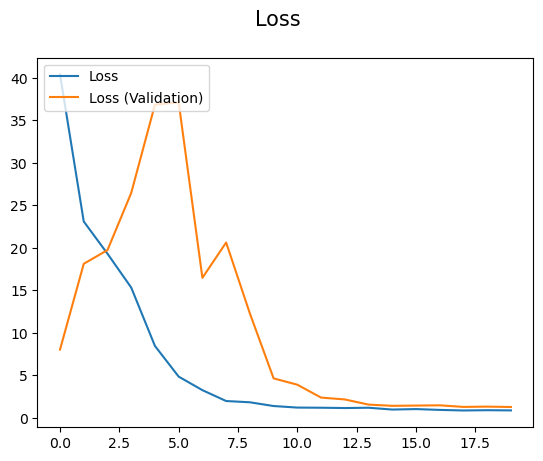

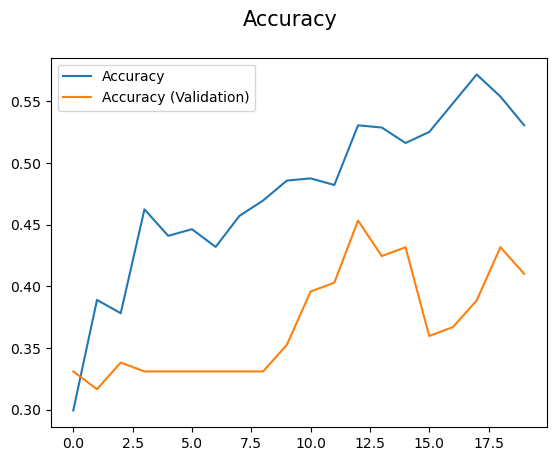

In [44]:
# plotting loss function
fig = plt.figure()
plt.plot(trained_model.history['loss'], label = 'Loss')
plt.plot(trained_model.history['val_loss'], label = 'Loss (Validation)')
fig.suptitle('Loss', fontsize = 15)
plt.legend(loc = "upper left")
plt.show()

# plotting accuracy function
fig = plt.figure()
plt.plot(trained_model.history['accuracy'], label = 'Accuracy')
plt.plot(trained_model.history['val_accuracy'], label = 'Accuracy (Validation)')
fig.suptitle('Accuracy', fontsize = 15)
plt.legend(loc = "upper left")
plt.show()

In [45]:
# evaluating accuracy on the testing set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

5/5 [==============================] - 3s 611ms/step - loss: 1.2910 - accuracy: 0.4101
Test Accuracy: 41.01%


1/1 [==============================] - 0s 187ms/step
Predicted class: m-type


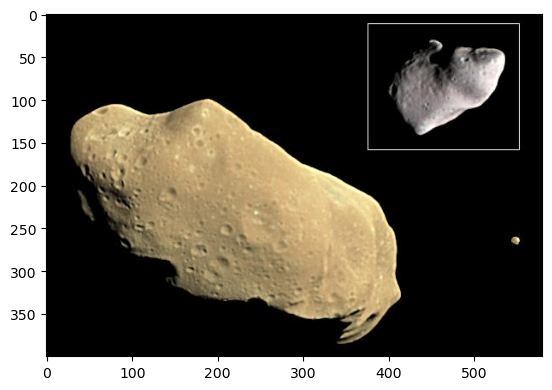

In [46]:
# making predictions on a sample image
test_image_path = "images_asteroids\m-type\ida-dact.jpg"
test_image = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
test_image = tf.image.resize(test_image, (256, 256))
test_image = np.expand_dims(test_image / 255, 0)

predictions = model.predict(test_image)
predicted_class = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())

print(f"Predicted class: {class_labels[predicted_class]}")